In [1]:
import numpy as np
from pydae.svg_tools import results2svg,svg
from IPython.core.display import HTML,SVG,display

In [2]:
import acdc_3ac_2dc

In [3]:
model = acdc_3ac_2dc.model()
model.ini({"K_p_agc":0.0, "K_i_agc":0.0,"K_delta_AC1":1.0,"K_agc_AC1":1.0,"K_xif":0.01,
             "p_load_AC4_a":-10e3/3,"p_load_AC4_b":-10e3/3,"p_load_AC4_c":-10e3/3,
             "p_DC4":500e3 },'xy_0.json') #'xy_0.json')
# model.report_x()
# model.report_y()
# model.report_z()


Input or parameter K_delta_AC1 not found.
Input or parameter K_agc_AC1 not found.


True

In [23]:
from xml.etree import ElementTree as ET
from xml.etree.ElementTree import Element

def set_tooltips_v2(self, output_file):
        
    s = self
    grid = self.grid
    
    for bus in s.grid_data['buses']:
        bus_id = bus['name']
        bus_elm_list = s.root.findall(f".//*[@id='{bus_id}']")
        if len(bus_elm_list) > 0:
            bus_elm = bus_elm_list[0]
        else:
            print(f'SVG element {bus_id} not found')
            continue

        if f"V_{bus['name']}_3_r" in grid.y_ini_list:
            v_n_r,v_n_i = grid.get_mvalue([f"V_{bus['name']}_3_r",f"V_{bus['name']}_3_i"])
            v_n = v_n_r + 1j*v_n_i
        else:
            v_n = 0.0
        for ph,da in zip(['0','1','2'],['data1','data2','data3']):
            V_r_id,V_i_id = f"V_{bus['name']}_{ph}_r",f"V_{bus['name']}_{ph}_i"
            if V_r_id in grid.y_ini_list:
                v_r,v_i =  grid.get_mvalue([V_r_id,V_i_id])
                v = v_r + 1j*v_i
                v_m = np.abs(v-v_n)
            if 'acdc' in bus:
                v_base = bus['U_kV']*1000
            else:
                v_base = bus['U_kV']*1000/np.sqrt(3)
            bus_elm.attrib[da] =f"{v_m:20.1f} V / {v_m/v_base:9.2f} pu "
        bus_elm.attrib['data4'] =f"{np.abs(v_n):20.1f} V"   
        bus_elm.attrib['data0'] = 'bus'

        p_load_a,q_load_a = -0.001,-0.001
        p_load_b,q_load_b = -0.001,-0.001
        p_load_c,q_load_c = -0.001,-0.001
        if f"p_load_{bus_id}_a" in grid.u_ini_list:
            p_load_a = grid.get_value(f"p_load_{bus_id}_a")
            q_load_a = grid.get_value(f"q_load_{bus_id}_a")
            p_load_b = grid.get_value(f"p_load_{bus_id}_b")
            q_load_b = grid.get_value(f"q_load_{bus_id}_b")
            p_load_c = grid.get_value(f"p_load_{bus_id}_c")
            q_load_c = grid.get_value(f"q_load_{bus_id}_c")
        p_load = p_load_a + p_load_b + p_load_c
        q_load = q_load_a + q_load_b + q_load_c

        bus_elm.attrib['data5'] =f"{p_load/1e3:20.1f} kW" 
        bus_elm.attrib['data6'] =f"{q_load/1e3:20.1f} kvar" 
        bus_elm.attrib['data7'] ="xx" 

        bus_elm.attrib['class'] = 'tooltip-trigger'

    for line in s.grid_data['lines']:

        bus_j = line['bus_j']
        bus_k = line['bus_k']

        for ph in ['0','1','2','3']:

            line_id = f'l_{bus_j}_{ph}_{bus_k}_{ph}'
            line_svg =  s.root.findall(f".//*[@id='{line_id}']")
            if len(line_svg)>0:
                line_elm = line_svg[0]
            else:
                continue
            line_elm.attrib['data0'] = 'line'

            for phi,da in zip(['0','1','2','3'],['data1','data2','data3','data4']):
                meas_line_id = f'l_{bus_j}_{phi}_{bus_k}_{phi}'

                i_m = 0.0

                if f'i_{meas_line_id}_r' in grid.outputs_list:
                    i_r,i_i =  grid.get_mvalue([f"i_{meas_line_id}_r",f"i_{meas_line_id}_i"])
                    i = i_r + 1j*i_i
                    i_m = np.abs(i)      
                v_base = 1.0
                line_elm.attrib[da] =f"{i_m:20.1f} A / {i_m/v_base:9.2f} pu "

            line_elm.attrib['class'] = 'tooltip-trigger'

    for trafo in s.grid_data['transformers']:
        bus_j = trafo['bus_j']
        bus_k = trafo['bus_k']

        for wind in [1,2]:
            trafo_id = f'trafo_{bus_j}_{bus_k}_{wind}'

            trafo_svg =  s.root.findall(f".//*[@id='{trafo_id}']")
            if len(trafo_svg)>0:
                trafo_elm = trafo_svg[0]
            else:
                print(f'No trafo {trafo_id} found')
                continue

            trafo_elm.attrib['data0'] = 'trafo'

            string_1 = ''
            for ph in ['0','1','2']:
                i_r_id = f'i_t_{bus_j}_{bus_k}_{ph}_r'
                if i_r_id in grid.outputs_list:
                    i_r,i_i =  grid.get_mvalue([i_r_id,f'i_t_{bus_j}_{bus_k}_1_{ph}_i'])
                    i = i_r + 1j*i_i
                    i_m = np.abs(i)  
                    string_1 += f'{ph}:  {i_m:0.2f}\t'

            string_2 = ''
            for ph in ['0','1','2','3']:
                i_r_id = f'i_t_{bus_j}_{bus_k}_1_{ph}_r'
                if i_r_id in grid.outputs_list:
                    i_r,i_i =  grid.get_mvalue([f'i_t_{bus_j}_{bus_k}_2_{ph}_r',f'i_t_{bus_j}_{bus_k}_2_{ph}_i'])
                    i = i_r + 1j*i_i
                    i_m = np.abs(i)  
                    string_2 += f'{ph}: {i_m:0.2f}     '

            trafo_elm.attrib['data1'] = string_1 + ' A'
            trafo_elm.attrib['data2'] = string_2 + ' A'
            trafo_elm.attrib['data3'] = 'trafo'
            trafo_elm.attrib['data4'] = 'trafo'
        trafo_elm.attrib['class'] = 'tooltip-trigger'

    if 'vscs' in self.grid_data:
        vscs_list = self.grid_data['vscs']
    else:
        vscs_list = []
        
    for vsc in vscs_list:

        if not 'bus_ac' in vsc: continue

        bus_ac = vsc['bus_ac']
        bus_dc = vsc['bus_dc']
        vsc_id = f'vsc_{bus_ac}_{bus_dc}'

        vsc_svg =  s.root.findall(f".//*[@id='{vsc_id}']")
        if len(vsc_svg)>0:
            vsc_elm = vsc_svg[0]
        else:
            print(f'No VSC {vsc_id} found')
            continue
        vsc_elm.attrib['data0'] = 'vsc'
        p_dc = grid.get_value(f'p_vsc_{bus_dc}')
        vsc_elm.attrib['data1'] = 'VSC'

        p_ac = grid.get_value(f'p_vsc_{bus_ac}')   
        p_dc = grid.get_value(f'p_vsc_{bus_dc}')   
        vsc_elm.attrib['data2'] = f'  Pac = {p_ac/1e3:0.1f} kW,  Pdc = {p_dc/1e3:0.1f} kW'

        p_loss = grid.get_value(f'p_vsc_loss_{bus_ac}')
        vsc_elm.attrib['data3'] = f'  Losses = {p_loss/1e3:0.1f} kW'

        vsc_elm.attrib['class'] = 'tooltip-trigger'
        
    script = '''
    <![CDATA[
            (function() {
                var svg = document.getElementById('document_id');
                var tooltip_1 = svg.getElementById('tooltip1');
            var tooltipText_1_1 = tooltip_1.getElementsByTagName('text')[0];
            var tooltipText_1_2 = tooltip_1.getElementsByTagName('text')[1];
            var tooltipText_1_3 = tooltip_1.getElementsByTagName('text')[2];
            var tooltipText_1_4 = tooltip_1.getElementsByTagName('text')[3];
            var tooltipText_1_5 = tooltip_1.getElementsByTagName('text')[4];
            var tooltipText_1_6 = tooltip_1.getElementsByTagName('text')[5];
                var tooltip_2 = svg.getElementById('tooltip2');
            var tooltipText_2_1 = tooltip_2.getElementsByTagName('text')[0];
            var tooltipText_2_2 = tooltip_2.getElementsByTagName('text')[1];
            var tooltipText_2_3 = tooltip_2.getElementsByTagName('text')[2];
            var tooltipText_2_4 = tooltip_2.getElementsByTagName('text')[3];
            var tooltipText_2_5 = tooltip_2.getElementsByTagName('text')[4];
            var tooltipText_2_6 = tooltip_2.getElementsByTagName('text')[5];
                var tooltip_3 = svg.getElementById('tooltip3');
            var tooltipText_3_1 = tooltip_3.getElementsByTagName('text')[0];
            var tooltipText_3_2 = tooltip_3.getElementsByTagName('text')[1];
            var tooltipText_3_3 = tooltip_3.getElementsByTagName('text')[2];
            var tooltipText_3_4 = tooltip_3.getElementsByTagName('text')[3];
    
            var tooltipRects = tooltip_1.getElementsByTagName('rect');
            var triggers = svg.getElementsByClassName('tooltip-trigger');
            for (var i = 0; i < triggers.length; i++) {
                triggers[i].addEventListener('mousemove', showTooltip);
                triggers[i].addEventListener('mouseout', hideTooltip);
            }
            function showTooltip(evt) {
                var CTM = svg.getScreenCTM();
                var x_unsat =  (evt.clientX - CTM.e) / CTM.a
                var x = x_unsat;
                if  (x_unsat>x_max) {var x = x_max}
                if  (x_unsat<x_min) {var x = x_min}
    
                
                var y_unsat = (evt.clientY - CTM.f) / CTM.d + 30;
                var y = y_unsat;
                if  (y_unsat>y_max) {var y = y_max - y_height}
                
                
                if (evt.target.getAttributeNS(null, "data0") == "bus") {
                    tooltip_1.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                    tooltip_1.setAttributeNS(null, "visibility", "visible")}
                
                if (evt.target.getAttributeNS(null, "data0") == "line") {
                    tooltip_2.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                    tooltip_2.setAttributeNS(null, "visibility", "visible")}
    
                if (evt.target.getAttributeNS(null, "data0") == "vsc") {
                    tooltip_3.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                    tooltip_3.setAttributeNS(null, "visibility", "visible")}
                    
                if (evt.target.getAttributeNS(null, "data0") == "trafo") {
                    tooltip_3.setAttributeNS(null, "transform", "translate(" + x + " " + y + ")");
                    tooltip_3.setAttributeNS(null, "visibility", "visible")}    
                    
                tooltipText_1_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
                tooltipText_1_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
                tooltipText_1_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
                tooltipText_1_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
                tooltipText_1_5.firstChild.data = evt.target.getAttributeNS(null, "data5");
                tooltipText_1_6.firstChild.data = evt.target.getAttributeNS(null, "data6");
        
                tooltipText_2_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
                tooltipText_2_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
                tooltipText_2_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
                tooltipText_2_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
                tooltipText_2_5.firstChild.data = evt.target.getAttributeNS(null, "data5");
                tooltipText_2_6.firstChild.data = evt.target.getAttributeNS(null, "data6");
    
                tooltipText_3_1.firstChild.data = evt.target.getAttributeNS(null, "data1");
                tooltipText_3_2.firstChild.data = evt.target.getAttributeNS(null, "data2");
                tooltipText_3_3.firstChild.data = evt.target.getAttributeNS(null, "data3");
                tooltipText_3_4.firstChild.data = evt.target.getAttributeNS(null, "data4");
                
                    var length = tooltipText_1_1.getComputedTextLength()+200;
                    for (var i = 0; i < tooltipRects.length; i++) {
                        tooltipRects[i].setAttributeNS(null, "width", length + 8);
                    }
                }
                function hideTooltip(evt) {
                    tooltip_1.setAttributeNS(null, "visibility", "hidden");
                    tooltip_2.setAttributeNS(null, "visibility", "hidden");
                    tooltip_3.setAttributeNS(null, "visibility", "hidden");
                }
            })()
        ]]>'''
    
    
    
    element = Element('script')
    element.attrib['type'] ="text/ecmascript"
    element.attrib['id'] = "script15"
    element.text = 'scriptplace'
    self.root.append(element)
    
    self.set_lines_currents_v2()
    self.set_buses_voltages_v2()
        
    out = self.tostring().replace('scriptplace',script)
    width = float(self.root.attrib['width'])
    height = float(self.root.attrib['height'])
    document_id = self.root.attrib['id']
    
    tooltip_width = 320
    tooltip_height = 100
    
    out=out.replace('x_max',f'{width-tooltip_width/2}' )
    out=out.replace('x_min',f'{tooltip_width/2}' )
    out=out.replace('y_max',f'{height-tooltip_height}' )
    out=out.replace('y_height',f'{tooltip_height}' )
    out=out.replace('document_id', document_id)
    
    with open(output_file,'w') as fobj:
        fobj.write(out)     

Input or parameter K_delta_AC1 not found.
Input or parameter K_agc_AC1 not found.


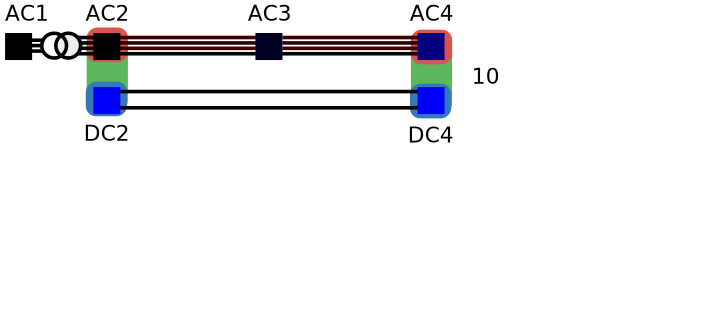

In [30]:
model = acdc_3ac_2dc.model()
model.ini({"K_p_agc":0.0, "K_i_agc":0.0,"K_delta_AC1":1.0,"K_agc_AC1":1.0,"K_xif":0.01,
             "p_load_AC4_a":200e3/3,"p_load_AC4_b":0e3/3,"p_load_AC4_c":200e3/3,
             "p_DC4":50e3,
             'p_vsc_a_AC4':20e3,'p_vsc_b_AC4':-40e3,'p_vsc_c_AC4':20e3},'xy_0.json') #'xy_0.json')

s = svg('acdc_3ac_2dc_v2.svg')
s.set_grid(model,'acdc_3ac_2dc.json')
s.set_text('PLOSS','10') 
set_tooltips_v2(s,f'acdc_3ac_2dc_tooltips.svg')   
SVG(f'acdc_3ac_2dc_tooltips.svg')

In [25]:
model.report_u()

p_load_AC4_a =66666.67
q_load_AC4_a = 0.00
g_load_AC4_a = 0.00
b_load_AC4_a = 0.00
p_load_AC4_b = 0.00
q_load_AC4_b = 0.00
g_load_AC4_b = 0.00
b_load_AC4_b = 0.00
p_load_AC4_c =66666.67
q_load_AC4_c = 0.00
g_load_AC4_c = 0.00
b_load_AC4_c = 0.00
p_DC4 =50000.00
v_dc_DC2_ref =800.00
q_vsc_a_AC2 = 0.00
q_vsc_b_AC2 = 0.00
q_vsc_c_AC2 = 0.00
v_dc_DC4_ref =800.00
p_vsc_a_AC4 = 0.00
p_vsc_b_AC4 = 0.00
p_vsc_c_AC4 = 0.00
q_vsc_a_AC4 = 0.00
q_vsc_b_AC4 = 0.00
q_vsc_c_AC4 = 0.00
e_ao_m_AC1 =11547.01
e_bo_m_AC1 =11547.01
e_co_m_AC1 =11547.01
phi_AC1 = 0.00
u_freq = 0.00


In [12]:
model.y_ini_list

['V_AC1_0_r',
 'V_AC1_0_i',
 'V_AC1_1_r',
 'V_AC1_1_i',
 'V_AC1_2_r',
 'V_AC1_2_i',
 'V_AC2_0_r',
 'V_AC2_0_i',
 'V_AC2_1_r',
 'V_AC2_1_i',
 'V_AC2_2_r',
 'V_AC2_2_i',
 'V_AC2_3_r',
 'V_AC2_3_i',
 'V_AC3_0_r',
 'V_AC3_0_i',
 'V_AC3_1_r',
 'V_AC3_1_i',
 'V_AC3_2_r',
 'V_AC3_2_i',
 'V_AC3_3_r',
 'V_AC3_3_i',
 'V_AC4_0_r',
 'V_AC4_0_i',
 'V_AC4_1_r',
 'V_AC4_1_i',
 'V_AC4_2_r',
 'V_AC4_2_i',
 'V_AC4_3_r',
 'V_AC4_3_i',
 'V_DC2_0_r',
 'V_DC2_0_i',
 'V_DC2_1_r',
 'V_DC2_1_i',
 'V_DC4_0_r',
 'V_DC4_0_i',
 'V_DC4_1_r',
 'V_DC4_1_i',
 'i_load_AC4_a_r',
 'i_load_AC4_a_i',
 'i_load_AC4_b_r',
 'i_load_AC4_b_i',
 'i_load_AC4_c_r',
 'i_load_AC4_c_i',
 'i_load_AC4_n_r',
 'i_load_AC4_n_i',
 'i_load_DC4_p_r',
 'p_a_d_AC2',
 'p_b_d_AC2',
 'p_c_d_AC2',
 'p_n_d_AC2',
 'i_vsc_AC2_a_r',
 'i_vsc_AC2_a_i',
 'i_vsc_AC2_b_r',
 'i_vsc_AC2_b_i',
 'i_vsc_AC2_c_r',
 'i_vsc_AC2_c_i',
 'i_vsc_AC2_n_r',
 'i_vsc_AC2_n_i',
 'i_vsc_pos_DC2_sp',
 'i_vsc_DC2_sn',
 'v_og_DC2',
 'p_vsc_DC2',
 'i_vsc_AC4_a_r',
 'i_vsc_AC4_a_

In [13]:
model.ini({"p_load_B2_a":10e3,"p_load_B2_b":10e3,"p_load_B2_c":10E3},'xy_0.json')
model.report_y()

Input or parameter p_load_B2_a not found.
Input or parameter p_load_B2_b not found.
Input or parameter p_load_B2_c not found.
V_AC1_0_r = 11546.98
V_AC1_0_i = -0.27
V_AC1_1_r = -5773.72
V_AC1_1_i = -9999.84
V_AC1_2_r = -5773.26
V_AC1_2_i = 10000.11
V_AC2_0_r = 199.38
V_AC2_0_i = -116.11
V_AC2_1_r = -200.24
V_AC2_1_i = -114.61
V_AC2_2_r =  0.87
V_AC2_2_i = 230.72
V_AC2_3_r =  0.00
V_AC2_3_i = -0.00
V_AC3_0_r = 199.66
V_AC3_0_i = -116.14
V_AC3_1_r = -200.39
V_AC3_1_i = -114.82
V_AC3_2_r =  0.75
V_AC3_2_i = 230.93
V_AC3_3_r = -0.02
V_AC3_3_i =  0.03
V_AC4_0_r = 199.95
V_AC4_0_i = -116.16
V_AC4_1_r = -200.54
V_AC4_1_i = -115.03
V_AC4_2_r =  0.62
V_AC4_2_i = 231.13
V_AC4_3_r = -0.03
V_AC4_3_i =  0.05
V_DC2_0_r = 400.00
V_DC2_0_i = -0.00
V_DC2_1_r = -400.00
V_DC2_1_i = -0.00
V_DC4_0_r = 394.65
V_DC4_0_i = -0.00
V_DC4_1_r = -394.65
V_DC4_1_i = -0.00
i_load_AC4_a_r = 12.46
i_load_AC4_a_i = -7.24
i_load_AC4_b_r = -12.50
i_load_AC4_b_i = -7.18
i_load_AC4_c_r =  0.04
i_load_AC4_c_i = 14.42
i_load

In [11]:
%%timeit 

for load in np.arange(0,200e3,10e3):
    model.spini({"p_load_B1_a":10e3,"p_load_B1_b":10e3,"p_load_B1_c":load},'xy_0.json')


Input or parameter p_load_B1_a not found.
Input or parameter p_load_B1_b not found.
Input or parameter p_load_B1_c not found.


AttributeError: 'model' object has no attribute 'P_d'

In [10]:
%%timeit 

for load in np.arange(0,200e3,10e3):
    model.ini({"p_load_B1_a":10e3,"p_load_B1_b":10e3,"p_load_B1_c":load},'xy_0.json')

3.71 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
